In [6]:
import math
import os
import random
import numpy as np
import pandas as pd
import re
import unidecode
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,Embedding, LSTM
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [3]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 7.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
text_file_path = '/content/drive/MyDrive/Data/EI-reg-En-anger-train.txt'
df2 = pd.read_csv(text_file_path, delimiter='\t')
df2.head(10)
csv_file_path = 'output.csv'
df2.to_csv(csv_file_path, index=False)

In [8]:
df=pd.read_csv("output.csv")
df.head()

,ID,Tweet,Affect Dimension,Intensity Score
0,2017-En-10264,@xandraaa5 @amayaallyn6 shut up hashtags are c...,anger,0.562
1,2017-En-10072,it makes me so fucking irate jesus. nobody is ...,anger,0.750
2,2017-En-11383,Lol Adam the Bull with his fake outrage...,anger,0.417
3,2017-En-11102,@THATSSHAWTYLO passed away early this morning ...,anger,0.354
4,2017-En-11506,@Kristiann1125 lol wow i was gonna say really?...,anger,0.438


In [9]:
df["Affect"]=df["Affect Dimension"]
df["Intensity"]=df["Intensity Score"]
df = df.drop(columns=['Affect Dimension','Intensity Score'])
df.head()

,ID,Tweet,Affect,Intensity
0,2017-En-10264,@xandraaa5 @amayaallyn6 shut up hashtags are c...,anger,0.562
1,2017-En-10072,it makes me so fucking irate jesus. nobody is ...,anger,0.750
2,2017-En-11383,Lol Adam the Bull with his fake outrage...,anger,0.417
3,2017-En-11102,@THATSSHAWTYLO passed away early this morning ...,anger,0.354
4,2017-En-11506,@Kristiann1125 lol wow i was gonna say really?...,anger,0.438


In [10]:
df["Affect"].value_counts()


anger    1701
Name: Affect, dtype: int64

In [11]:
# Cleaning the text  from unnecessary characters
def clean_data(data):
    final = []
    for sent in data:
        sent = sent.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
        soup = BeautifulSoup(sent, "html.parser")
        sent = soup.get_text(separator=" ")
        remove_https = re.sub(r'http\S+', '', sent)
        sent = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
        sent = unidecode.unidecode(sent)
        sent = sent.lower()
        sent = re.sub(r"[^a-zA-Z0-9:$-,()%.?!]+", ' ', sent)
        sent = re.sub(r"[:$-,()%.?!]+", ' ',sent)
        stoplist = stopwords.words("english")
        sent = [word for word in word_tokenize(sent) if word not in stoplist]
        sent = " ".join(sent)
        final.append(sent)
    return final

# Return the probability from output number
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Set seed to get the same output everytime
def seed_everything(SEED=13):
    np.random.seed(SEED)
    random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'
    os.environ['PYTHONHASHSEED'] = str(SEED)

seed_everything()


In [12]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
df["Tweet"] = clean_data(df["Tweet"])

<ipython-input-11-8661d540e0aa>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sent, "html.parser")


In [14]:
df['Intensity'] = df['Intensity'].apply(lambda x: 1 if x > 0.55 else 0)
df.head()

,ID,Tweet,Affect,Intensity
0,2017-En-10264,xandraaa5 amayaallyn6 shut hashtags cool offended,anger,1
1,2017-En-10072,makes fucking irate jesus nobody calling ppl l...,anger,1
2,2017-En-11383,lol adam bull fake outrage,anger,0
3,2017-En-11102,thatsshawtylo passed away early morning fast f...,anger,0
4,2017-En-11506,kristiann1125 lol wow gon na say really haha s...,anger,0


In [15]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)
#not using it since it gave bad results compared to other preprocessing funcition


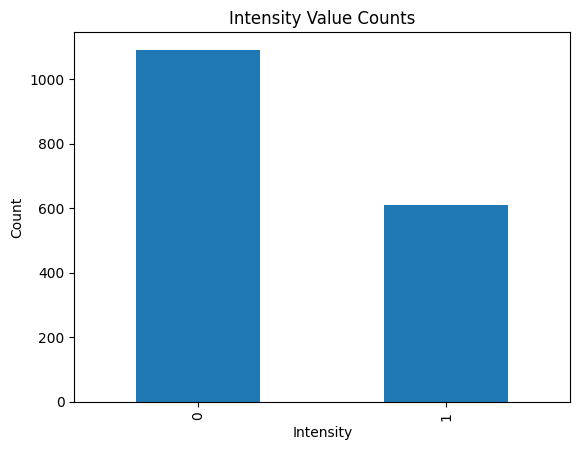

In [21]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with a column named "Intensity"
intensity_counts = df['Intensity'].value_counts()

# Plotting the counts of each intensity value
intensity_counts.plot(kind='bar')
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Intensity Value Counts')
plt.show()


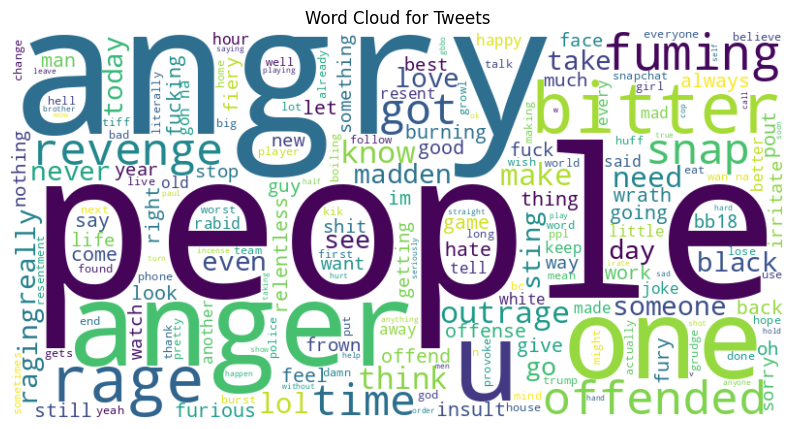

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with a column named "tweet"
text_data = ' '.join(df['Tweet'].astype(str))

# Generate a WordCloud object
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text_data)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Tweets')
plt.show()


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.Tweet,
    df.Intensity,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df.Intensity
)

In [23]:



from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter
     ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.80      0.86      0.83       219
           1       0.71      0.61      0.65       122

    accuracy                           0.77       341
   macro avg       0.75      0.73      0.74       341
weighted avg       0.77      0.77      0.77       341



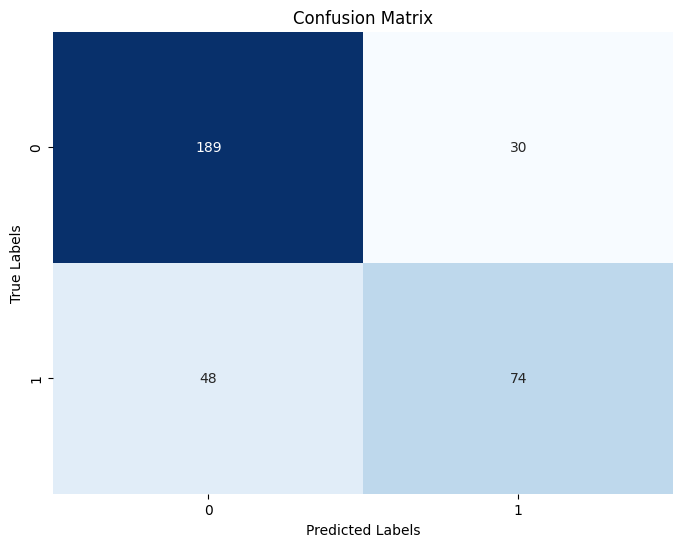

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are your true and predicted labels, respectively

# 5. Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Assuming you have X_train, X_test, y_train, y_test from your dataset

# 1. Create a pipeline object
rf_clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1, 1))),
    ('Random Forest', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# 2. Fit with X_train and y_train
rf_clf.fit(X_train, y_train)

# 3. Get the predictions for X_test and store it in y_pred
y_pred = rf_clf.predict(X_test)

# 4. Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.87      0.82       219
           1       0.70      0.56      0.62       122

    accuracy                           0.76       341
   macro avg       0.74      0.71      0.72       341
weighted avg       0.75      0.76      0.75       341



In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split



# 1. Create a pipeline object
catboost_clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1, 1))),
    ('CatBoost', CatBoostClassifier(random_state=42, auto_class_weights='Balanced', verbose=0))
])

# 2. Fit with X_train and y_train
catboost_clf.fit(X_train, y_train)

# 3. Get the predictions for X_test and store it in y_pred
y_pred = catboost_clf.predict(X_test)

# 4. Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       219
           1       0.64      0.61      0.62       122

    accuracy                           0.74       341
   macro avg       0.71      0.71      0.71       341
weighted avg       0.73      0.74      0.74       341



In [ ]:
df.Intensity.value_counts()
#decent enough for our model lol
#lets try more algos

0    1091
1     610
Name: Intensity, dtype: int64

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Assuming you have X_train, X_test, y_train, y_test from your dataset

# 1. Create a pipeline object
decision_tree_clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1, 1))),#out of 1 to 15, 1 was best for ngram
    ('DecisionTree', DecisionTreeClassifier(random_state=123, class_weight='balanced'))
])

# 2. Fit with X_train and y_train
decision_tree_clf.fit(X_train, y_train)

# 3. Get the predictions for X_test and store it in y_pred
y_pred = decision_tree_clf.predict(X_test)

# 4. Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.76      0.78       219
           1       0.61      0.67      0.64       122

    accuracy                           0.73       341
   macro avg       0.71      0.72      0.71       341
weighted avg       0.73      0.73      0.73       341



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Assuming you have X_train, X_test, y_train, y_test from your dataset

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length
max_length = max(max(len(seq) for seq in X_train_seq), max(len(seq) for seq in X_test_seq))
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Define the RNN model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = (model.predict(X_test_padded) > 0.5).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred))


Epoch 1/5
34/34 [==============================] - 11s 163ms/step - loss: 0.6509 - accuracy: 0.6425 - val_loss: 0.6454 - val_accuracy: 0.6397
Epoch 2/5
34/34 [==============================] - 3s 86ms/step - loss: 0.5594 - accuracy: 0.7031 - val_loss: 0.5421 - val_accuracy: 0.7426
Epoch 3/5
34/34 [==============================] - 4s 99ms/step - loss: 0.1940 - accuracy: 0.9228 - val_loss: 0.7965 - val_accuracy: 0.5919
Epoch 4/5
34/34 [==============================] - 2s 54ms/step - loss: 0.1152 - accuracy: 0.9623 - val_loss: 0.8796 - val_accuracy: 0.6765
Epoch 5/5
11/11 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.77      0.72      0.75       219
           1       0.55      0.62      0.59       122

    accuracy                           0.69       341
   macro avg       0.66      0.67      0.67       341
weighted avg       0.70      0.69      0.69       341



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Assuming you have X_train, X_test, y_train, y_test from your dataset

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length
max_length = max(max(len(seq) for seq in X_train_seq), max(len(seq) for seq in X_test_seq))
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Define the RNN model with Dropout
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = (model.predict(X_test_padded) > 0.5).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred))


Epoch 1/5
34/34 [==============================] - 12s 123ms/step - loss: 0.6514 - accuracy: 0.6406 - val_loss: 0.6459 - val_accuracy: 0.6397
Epoch 2/5
34/34 [==============================] - 2s 69ms/step - loss: 0.5056 - accuracy: 0.7417 - val_loss: 0.6841 - val_accuracy: 0.6949
Epoch 3/5
34/34 [==============================] - 2s 62ms/step - loss: 0.1698 - accuracy: 0.9403 - val_loss: 0.7857 - val_accuracy: 0.6471
Epoch 4/5
34/34 [==============================] - 1s 38ms/step - loss: 0.0996 - accuracy: 0.9678 - val_loss: 0.7952 - val_accuracy: 0.6654
Epoch 5/5
11/11 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       219
           1       0.55      0.61      0.58       122

    accuracy                           0.68       341
   macro avg       0.66      0.67      0.66       341
weighted avg       0.69      0.68      0.69       341



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Assuming you have X_train, X_test, y_train, y_test from your dataset

# 1. Create a pipeline object
lr_clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1, 2))),
    ('DecisionTree', LogisticRegression(random_state=123, class_weight='balanced'))
])

# 2. Fit with X_train and y_train
lr_clf.fit(X_train, y_train)

# 3. Get the predictions for X_test and store it in y_pred
y_pred = lr_clf.predict(X_test)

# 4. Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       219
           1       0.68      0.65      0.66       122

    accuracy                           0.77       341
   macro avg       0.74      0.74      0.74       341
weighted avg       0.76      0.77      0.76       341

